In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense



In [39]:
# Load your continuous value data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AML Group/clean_data3.csv')  # Load your data from a CSV file or any other source




In [40]:
data.head()

,Unnamed: 0,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class,bioactivity_class_encoded
0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,active,0
1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,inactive,1
2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,active,0
3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,inactive,1
4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,5.1731,2.0,3.0,2.0,3.0,inactive,1


In [41]:
#Drop unnamed, moleculed_id, canonical smiles
columns_to_drop = ['Unnamed: 0','molecule_chembl_id','smiles','standard_units']
data = data.drop(columns_to_drop, axis=1)

In [42]:
data.head()

,standard_type,standard_value,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class,bioactivity_class_encoded
0,Ki,33.0,295.810,2.8477,0.0,3.0,1.0,2.0,active,0
1,Ki,314.0,295.810,2.8477,0.0,3.0,1.0,2.0,inactive,1
2,Ki,32.0,303.358,1.8677,0.0,5.0,1.0,3.0,active,0
3,Ki,388.0,303.358,1.8677,0.0,5.0,1.0,3.0,inactive,1
4,Ki,4140.0,435.178,5.1731,2.0,3.0,2.0,3.0,inactive,1


In [43]:
#Encode standard type
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['standard_type_encoded'] = label_encoder.fit_transform(data['standard_type'])
data['bioactivity_encoded'] = label_encoder.fit_transform(data['bioactivity_class'])
columns_to_drop = ['standard_type','bioactivity_class']
data = data.drop(columns_to_drop, axis=1)
data.head()

,standard_value,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class_encoded,standard_type_encoded,bioactivity_encoded
0,33.0,295.810,2.8477,0.0,3.0,1.0,2.0,0,3,0
1,314.0,295.810,2.8477,0.0,3.0,1.0,2.0,1,3,1
2,32.0,303.358,1.8677,0.0,5.0,1.0,3.0,0,3,0
3,388.0,303.358,1.8677,0.0,5.0,1.0,3.0,1,3,1
4,4140.0,435.178,5.1731,2.0,3.0,2.0,3.0,1,3,1


In [44]:

# Extract input features (X) and target variable (y)
X = data.drop('bioactivity_encoded', axis=1)  # Drop the target variable column from input features
y = data['bioactivity_encoded']  # Extract the target variable column

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Standardize the input features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
##X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3778, 9)
(3778,)
(1181, 9)
(1181,)


In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout

# define the model architecture
model = keras.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(9, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    keras.layers.Dense(units=3, activation='softmax')
])

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# reshape the input data to be compatible with the CNN architecture
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# define early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/30
119/119 [==============================] - 4s 13ms/step - loss: 2.5788 - accuracy: 0.8078 - val_loss: 1.0948 - val_accuracy: 0.8823
Epoch 2/30
119/119 [==============================] - 1s 6ms/step - loss: 1.0238 - accuracy: 0.8542 - val_loss: 0.8762 - val_accuracy: 0.8865
Epoch 3/30
119/119 [==============================] - 1s 8ms/step - loss: 0.8738 - accuracy: 0.8714 - val_loss: 0.8111 - val_accuracy: 0.8916
Epoch 4/30
119/119 [==============================] - 1s 6ms/step - loss: 0.7909 - accuracy: 0.8814 - val_loss: 0.7466 - val_accuracy: 0.8891
Epoch 5/30
119/119 [==============================] - 0s 4ms/step - loss: 0.7522 - accuracy: 0.8846 - val_loss: 0.7137 - val_accuracy: 0.8755
Epoch 6/30
119/119 [==============================] - 0s 4ms/step - loss: 0.7007 - accuracy: 0.8875 - val_loss: 0.6858 - val_accuracy: 0.8950
Epoch 7/30
119/119 [==============================] - 0s 4ms/step - loss: 0.6991 - accuracy: 0.8851 - val_loss: 0.6834 - val_accuracy: 0.8738
Epoch

In [47]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))



37/37 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 0.9856
Accuracy: 98.56


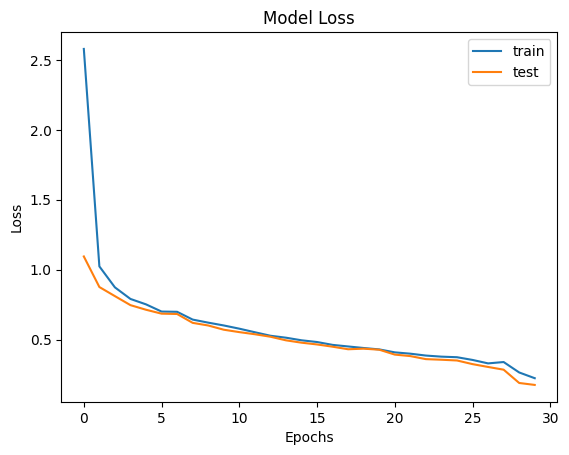

In [48]:
# Plot the loss function during training
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

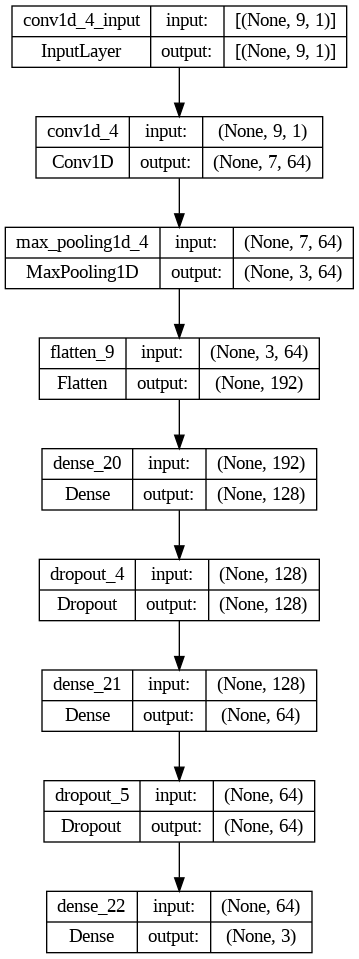

In [49]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)
Image('model.png')

In [51]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score

# Make predictions using your CNN model
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoding to labels
y_pred = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to labels
#y_test = np.argmax(y_test,axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy*100))

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision*100))

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print('F1 score: {:.2f}%'.format(f1*100))

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


37/37 [==============================] - 0s 3ms/step
Accuracy: 98.56%
Precision: 98.58%
F1 score: 98.55%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97       340
           1       0.98      1.00      0.99       841

    accuracy                           0.99      1181
   macro avg       0.99      0.98      0.98      1181
weighted avg       0.99      0.99      0.99      1181

